# 1. Import the necessary packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.datasets import fashion_mnist as fm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import plot_model

# 2. Define a function to load and prepare the dataset

In [2]:
def load_dataset():
    (X_train, y_train), (X_test, y_test) = fm.load_data()

    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    X_train = np.expand_dims(X_train, axis=3)
    X_test = np.expand_dims(X_test, axis=3)

    label_binarizer = LabelBinarizer()
    y_train = label_binarizer.fit_transform(y_train)
    y_test = label_binarizer.fit_transform(y_test)

    (X_train, X_val, y_train, y_val) = train_test_split(X_train, y_train, 
                                                        train_size=0.8)
    train_ds = (tf.data.Dataset.from_tensor_slices((X_train, y_train)))
    val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val)))
    test_ds = (tf.data.Dataset.from_tensor_slices((X_test, y_test)))

    return train_ds, val_ds, test_ds


# 3. Build a network

In [3]:
def build_network():
    input_layer = Input(shape=(28, 28, 1))
    x = Conv2D(filters=20,
               kernel_size=(5,5),
               padding='same',
               strides=(1,1))(input_layer)
    x = ELU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2),
                     strides=(2,2))(x)
    x = Dropout(rate=0.5)(x)

    x = Conv2D(filters = 50,
               kernel_size= (5,5),
               padding='same',
               strides=(1,1))(x)
    x = ELU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2),
                     strides=(1,1))(x)
    x = Dropout(rate=0.5)(x)

    x = Flatten()(x)
    x = Dense(units=500)(x)
    x = ELU()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=10)(x)

    output = Softmax()(x)

    model = Model(inputs=input_layer, outputs=output)
    return model
    

# 4. Defien a function that takes a model's history

In [4]:
def plot_model_history(model_history, metric, ylim=None):
    plt.style.use('seaborn-darkgrid')
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({'Model': model_history}, metric=metric)

    plt.title(f'{metric.upper()}')
    if ylim is None:
        plt.ylim([0, 1])
    else:
        plt.ylim(ylim)
    
    plt.savefig(f'{metric}.png')
    plt.close()

# 5. Consume the training and validation

In [5]:
BATCH_SIZE = 256
BUFFER_SIZE = 1024

train_dataset, val_dataset, test_dataset = load_dataset()

train_dataset = (train_dataset
                 .shuffle(buffer_size=BUFFER_SIZE)
                 .batch(BATCH_SIZE)
                 .prefetch(buffer_size=BUFFER_SIZE))
val_dataset = (val_dataset
               .batch(BATCH_SIZE)
               .prefetch(buffer_size=BUFFER_SIZE))
test_dataset = test_dataset.batch(BATCH_SIZE)


# 6. Build and train the network

In [6]:
EPOCHS = 25

model = build_network()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_history = model.fit(train_dataset, validation_data=val_dataset,
                          epochs=EPOCHS, verbose=0)

# 7. Plot training and validation loss and accuracy

In [7]:
plot_model_history(model_history, 'loss', [0., 2.0])
plot_model_history(model_history, 'accuracy')

# 8. Visualize model's archiecture

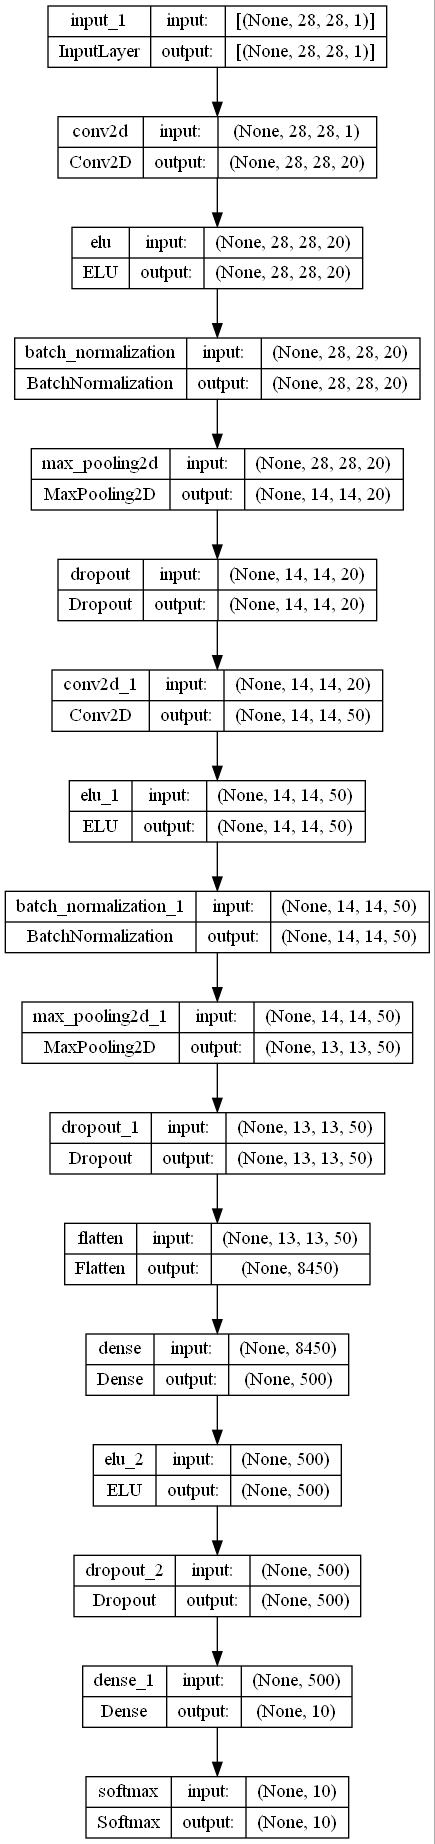

In [8]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file="model.jpg")

# 9. Save the model

In [10]:
model.save('model.hdf5')

# 10. Load and evaluate yhe model

In [11]:
loaded_model = load_model('model.hdf5')
results = loaded_model.evaluate(test_dataset, verbose=0)
print(f'Loss: {results[0]}, Accuracy: {results[1]}')

Loss: 0.296561062335968, Accuracy: 0.9083999991416931
